In [1]:
!pip install fractal-defi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.6/522.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0

#ETH, DOGE, PEPE and etc. funding rate analyze

In [2]:
from fractal.loaders.binance import BinanceFundingLoader
from fractal.loaders.hyperliquid import HyperliquidFundingRatesLoader, HyperLiquidPerpsPricesLoader
from fractal.loaders.thegraph.uniswap_v3 import UniswapV3EthereumPoolHourDataLoader
from datetime import datetime, UTC

import pandas as pd
import time
from typing import Optional

In [3]:
start_time = datetime(2023, 1, 1, tzinfo=UTC)
end_time = datetime(2025, 5, 1, tzinfo=UTC)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_negative_funding_periods(rate_df, rate_col='rate', threshold_prob=0.7,
                                    periods={'day': 'D', 'week': 'W', 'month': 'M'},
                                    plot_results=True, figsize=(14, 10)):
    """
    Анализирует периоды с высокой вероятностью отрицательной фандинговой ставки.

    Параметры:
    rate_df (pd.DataFrame): DataFrame с индексом времени и столбцом ставок
    rate_col (str): имя столбца со ставками
    threshold_prob (float): порог вероятности для определения "высоковероятных" периодов
    periods (dict): словарь с периодами для агрегации
    plot_results (bool): нужно ли визуализировать результаты
    figsize (tuple): размер графика
    """
    results = {}
    period_data = {}

    # Создаем булеву серию отрицательных ставок
    negative = rate_df[rate_col] < 0

    # Подсчитываем периоды для каждого временного интервала
    for period_name, period_alias in periods.items():
        # Группируем по периоду
        grouped = negative.resample(period_alias).agg(['sum', 'count'])
        # Вероятность отрицательной ставки в периоде
        grouped['prob_negative'] = grouped['sum'] / grouped['count']
        # Считаем количество периодов, где вероятность > threshold_prob
        high_prob_periods = grouped[grouped['prob_negative'] > threshold_prob]
        count_periods = len(high_prob_periods)

        results[period_name] = {
            'total_periods': len(grouped),
            'high_prob_periods': count_periods,
            'percentage': (count_periods / len(grouped) * 100) if len(grouped) > 0 else 0
        }

        period_data[period_name] = grouped

    # Визуализация результатов
    if plot_results:
        fig, axes = plt.subplots(len(periods) + 1, 1, figsize=figsize)

        # Гистограмма распределения ставок
        axes[0].hist(rate_df[rate_col], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Нулевая ставка')
        axes[0].set_title('Распределение фандинговых ставок', fontsize=14)
        axes[0].set_xlabel('Фандинговая ставка (%)', fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend()

        # Графики вероятности отрицательной ставки по периодам
        for i, (period_name, period_alias) in enumerate(periods.items(), 1):
            df = period_data[period_name]
            axes[i].plot(df.index, df['prob_negative'], marker='o', markersize=4,
                        linestyle='-', color='purple')
            axes[i].axhline(y=threshold_prob, color='red', linestyle='--',
                           label=f'Порог ({threshold_prob})')

            # Выделение периодов с высокой вероятностью
            high_prob_mask = df['prob_negative'] > threshold_prob
            if high_prob_mask.sum() > 0:
                axes[i].scatter(df.index[high_prob_mask],
                               df['prob_negative'][high_prob_mask],
                               color='red', s=35, zorder=5)

            axes[i].set_title(f'Вероятность отрицательной ставки по {period_name}', fontsize=14)
            axes[i].set_ylabel('Вероятность', fontsize=12)
            axes[i].set_ylim(0, 1.05)
            axes[i].grid(alpha=0.3)
            axes[i].legend()

            # Аннотация с результатами
            stats_text = (f"Всего периодов: {results[period_name]['total_periods']}\n"
                         f"С вероятностью > {threshold_prob}: {results[period_name]['high_prob_periods']} "
                         f"({results[period_name]['percentage']:.1f}%)")

            axes[i].annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
                            ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()

    return results, period_data

def plot_futures_price(futures_df, rate_df=None, rate_col='rate', price_col='price', figsize=(14, 6)):
    """
    Рисует график цены фьючерса на отдельной картинке.
    Если предоставлен DataFrame с фандинговой ставкой, также отмечает периоды с отрицательной ставкой.

    Параметры:
    futures_df (pd.DataFrame): DataFrame с индексом времени и колонкой цены фьючерса
    rate_df (pd.DataFrame): DataFrame с индексом времени и колонкой фандинговой ставки (опционально)
    rate_col (str): имя колонки с фандинговой ставкой (по умолчанию 'rate')
    price_col (str): имя колонки с ценой (по умолчанию 'price')
    figsize (tuple): размер графика
    """
    plt.figure(figsize=figsize)

    # Рисуем график цены фьючерса
    plt.plot(futures_df.index, futures_df[price_col], color='green', label='Цена фьючерса')

    # Если предоставлен DataFrame с фандинговой ставкой
    if rate_df is not None:
        # Объединяем данные для корректного отображения
        combined_df = pd.merge(futures_df[[price_col]], rate_df[[rate_col]],
                             left_index=True, right_index=True, how='inner')

        # Отмечаем точки, где фандинговая ставка отрицательна
        negative_mask = combined_df[rate_col] < 0
        if negative_mask.sum() > 0:
            plt.scatter(combined_df.index[negative_mask],
                       combined_df[price_col][negative_mask],
                       color='red', s=10, zorder=5,
                       label='Цена при отриц. ставке')

        # Находим непрерывные периоды с отрицательной ставкой
        neg_periods = []
        start_idx = None

        for i in range(len(combined_df.index)):
            if negative_mask.iloc[i]:
                if start_idx is None:
                    start_idx = i
            elif start_idx is not None:
                neg_periods.append((start_idx, i-1))
                start_idx = None

        if start_idx is not None:  # Если последний период тоже отрицательный
            neg_periods.append((start_idx, len(combined_df.index)-1))

        # Добавляем затенение для периодов с отрицательной ставкой
        for start, end in neg_periods:
            plt.axvspan(combined_df.index[start], combined_df.index[end],
                      color='gray', alpha=0.2)

        # Добавляем вторую ось Y для фандинговой ставки
        ax2 = plt.gca().twinx()
        ax2.plot(combined_df.index, combined_df[rate_col], color='purple', alpha=0.7,
                label='Фандинговая ставка')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax2.set_ylabel('Фандинговая ставка (%)', color='purple', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='purple')

        # Создаем общую легенду
        lines1, labels1 = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        plt.legend()

    plt.title('График цены фьючерса', fontsize=16)
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Цена', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Пример использования:
# 1. Только график цены фьючерса
# plot_futures_price(futures_df)

# 2. График цены фьючерса с отмеченными периодами отрицательной фандинговой ставки
# plot_futures_price(futures_df, rate_df)


<ipython-input-32-69cff84bdb1a>:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = negative.resample(period_alias).agg(['sum', 'count'])


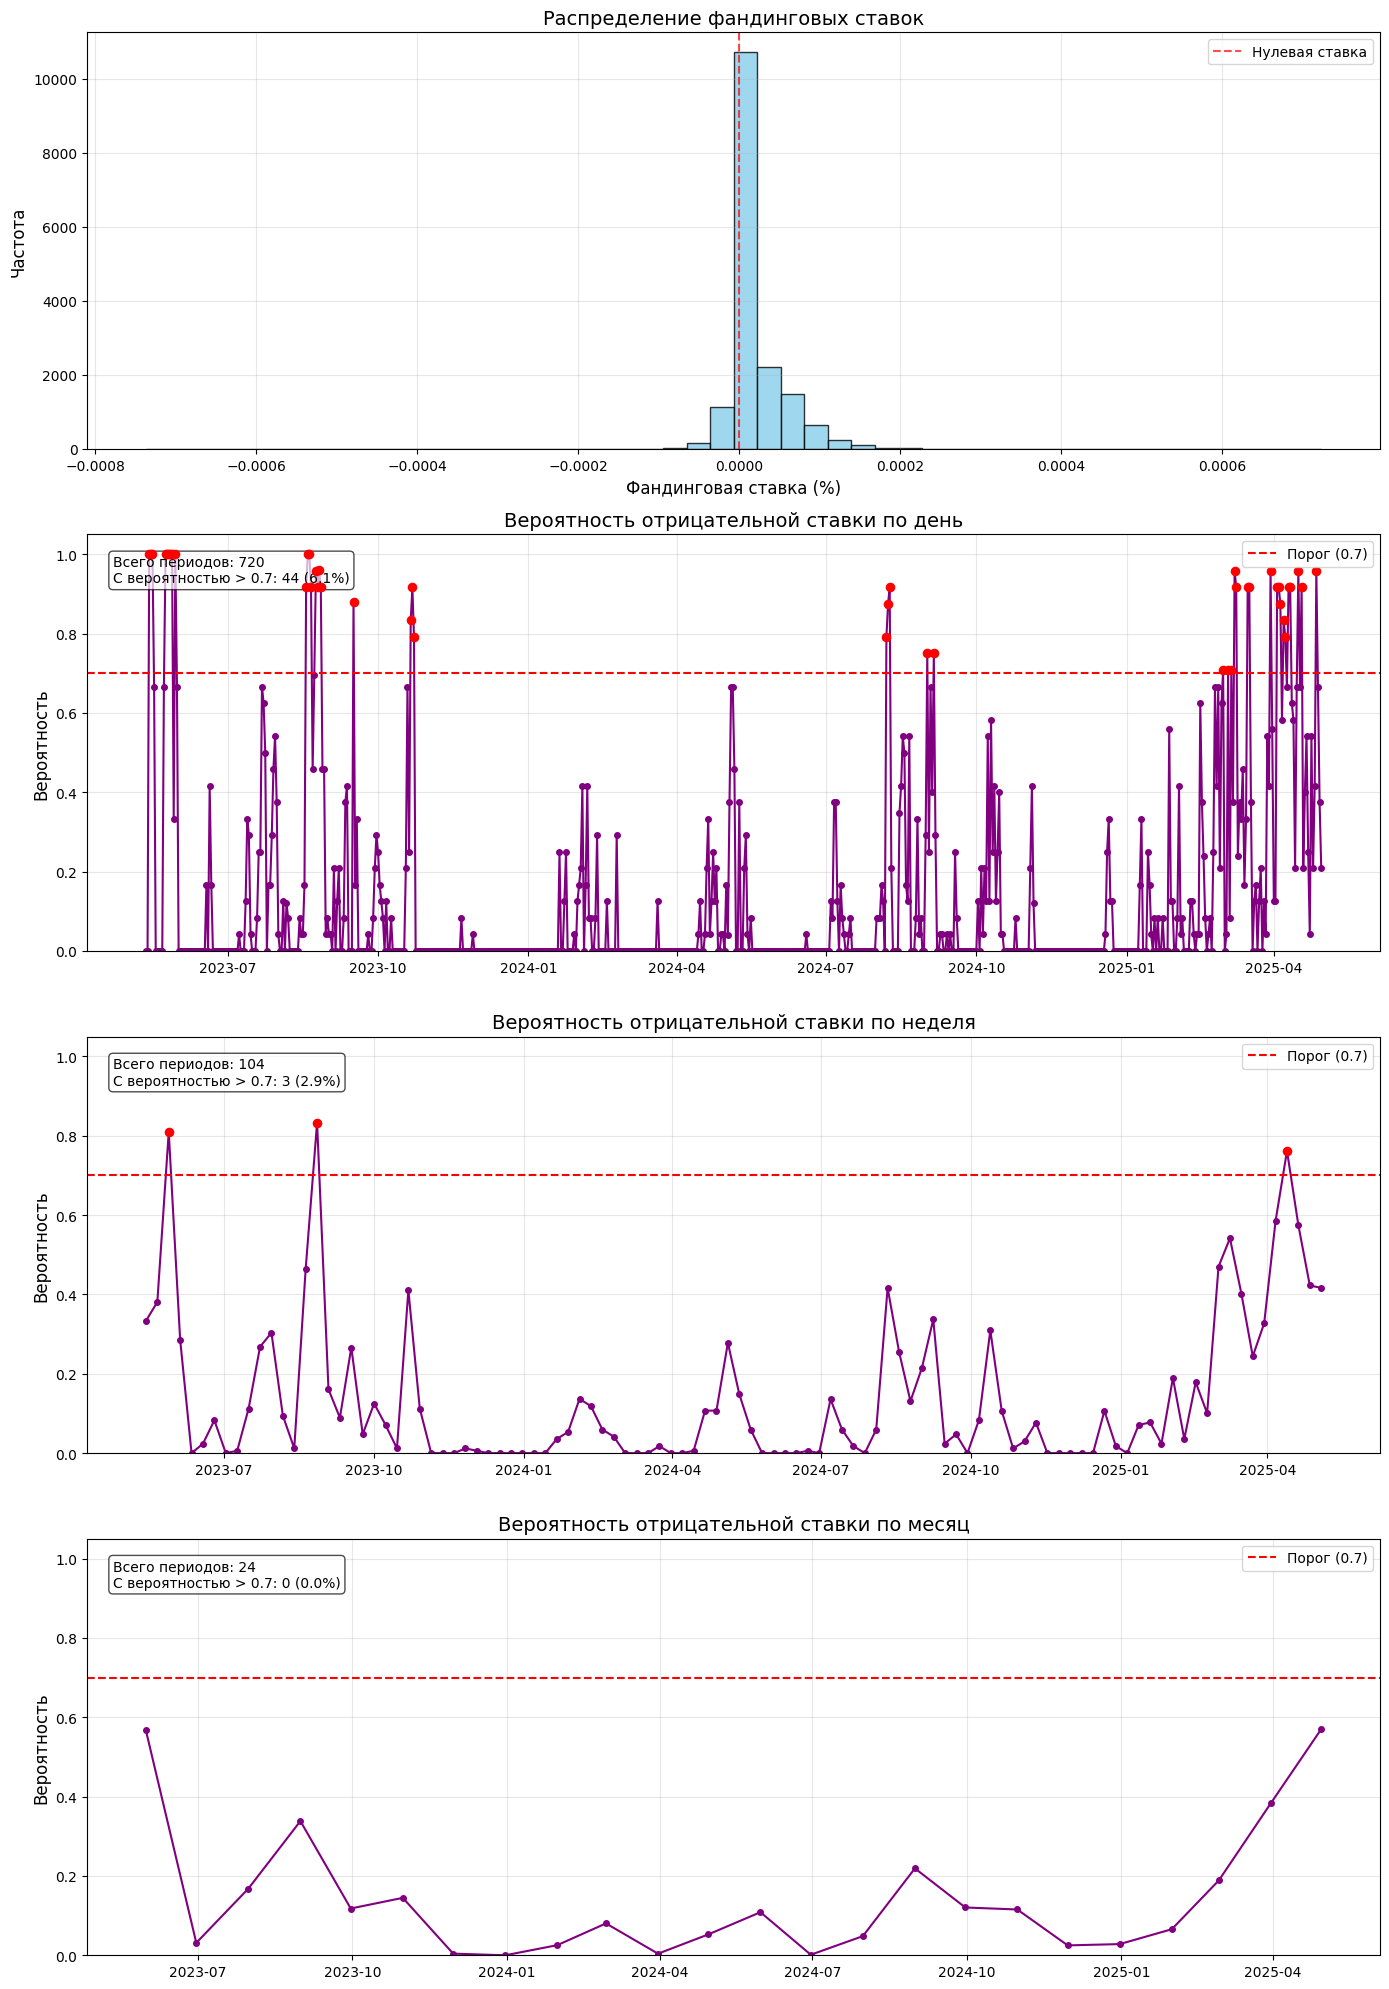

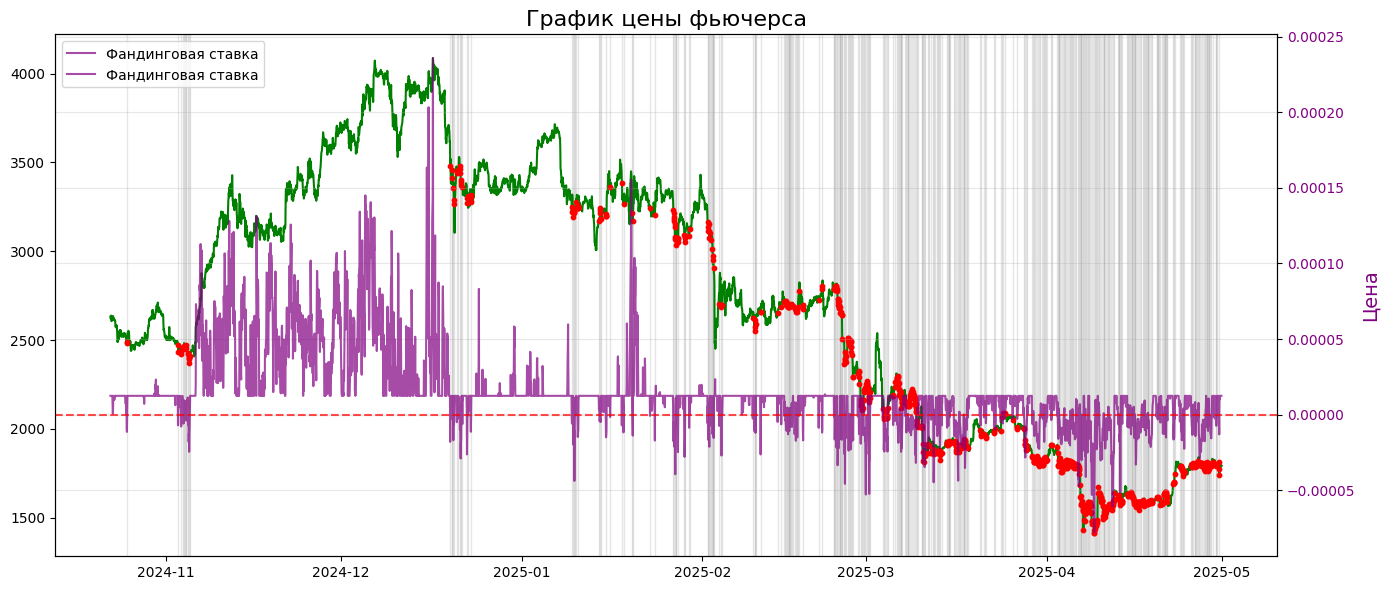


Результаты анализа периодов с высокой вероятностью отрицательной ставки:
день: 44 из 720 (6.1%)
неделя: 3 из 104 (2.9%)
месяц: 0 из 24 (0.0%)


In [33]:
# Генерация тестовых данных
# Анализируем данные
ETH_frs = HyperliquidFundingRatesLoader(ticker = 'ETH', start_time=start_time, end_time=end_time).read(with_run=True)
ETH_future_prices = HyperLiquidPerpsPricesLoader(ticker='ETH', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

results, _ = analyze_negative_funding_periods(
    ETH_frs,
    threshold_prob=0.7,
    figsize=(14, 20),
    periods={'день': 'D', 'неделя': 'W', 'месяц': 'M'}
)

plot_futures_price(ETH_future_prices, ETH_frs)

print("\nРезультаты анализа периодов с высокой вероятностью отрицательной ставки:")
for period, stats in results.items():
    print(f"{period}: {stats['high_prob_periods']} из {stats['total_periods']} "
          f"({stats['percentage']:.1f}%)")

<ipython-input-32-69cff84bdb1a>:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = negative.resample(period_alias).agg(['sum', 'count'])


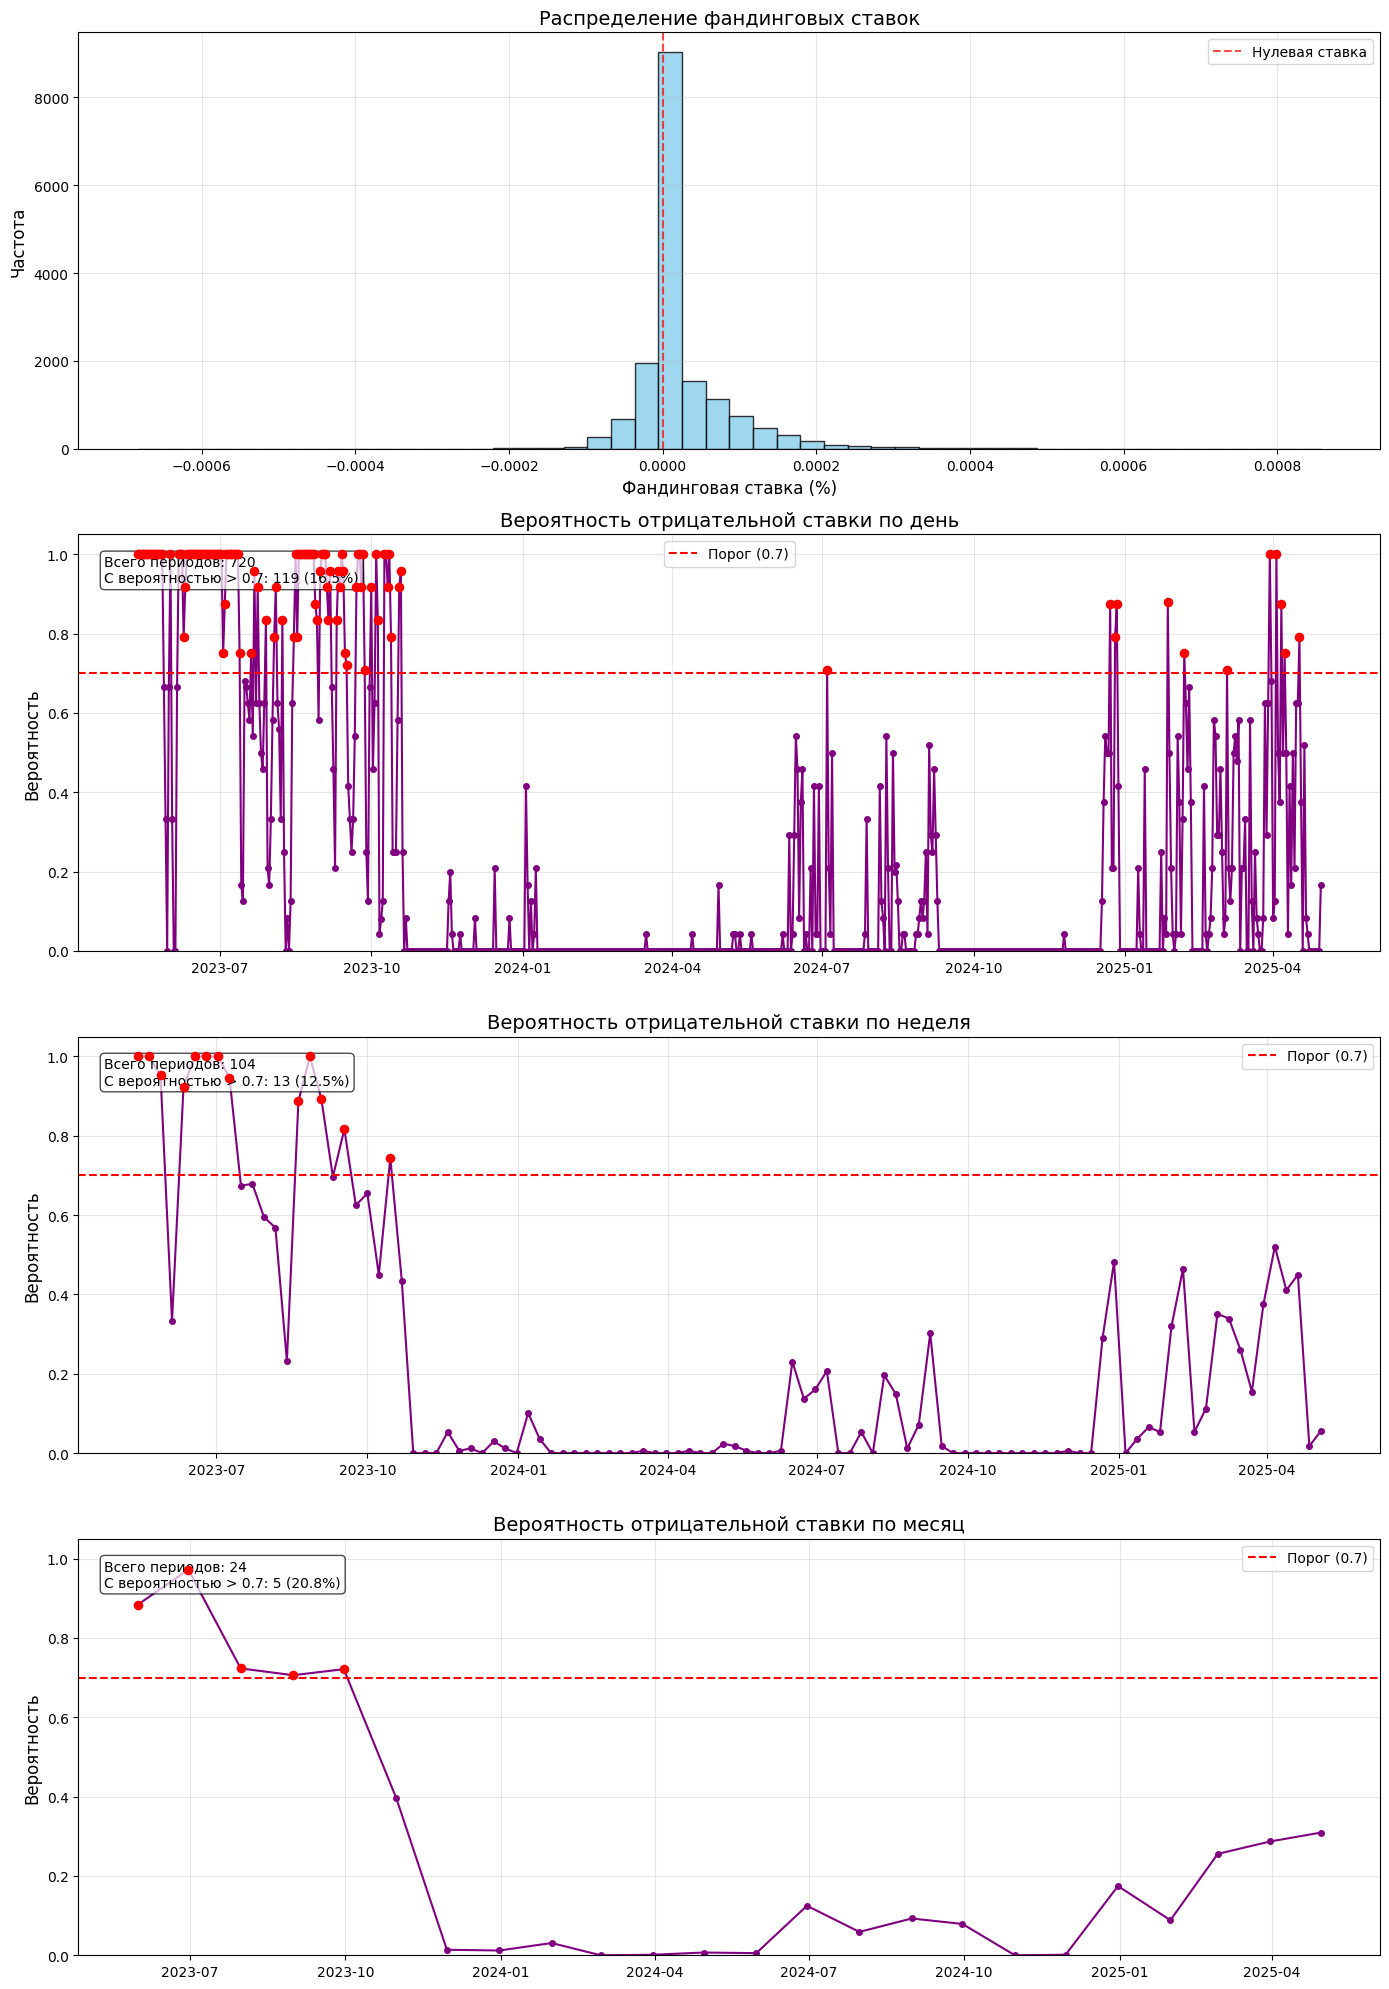

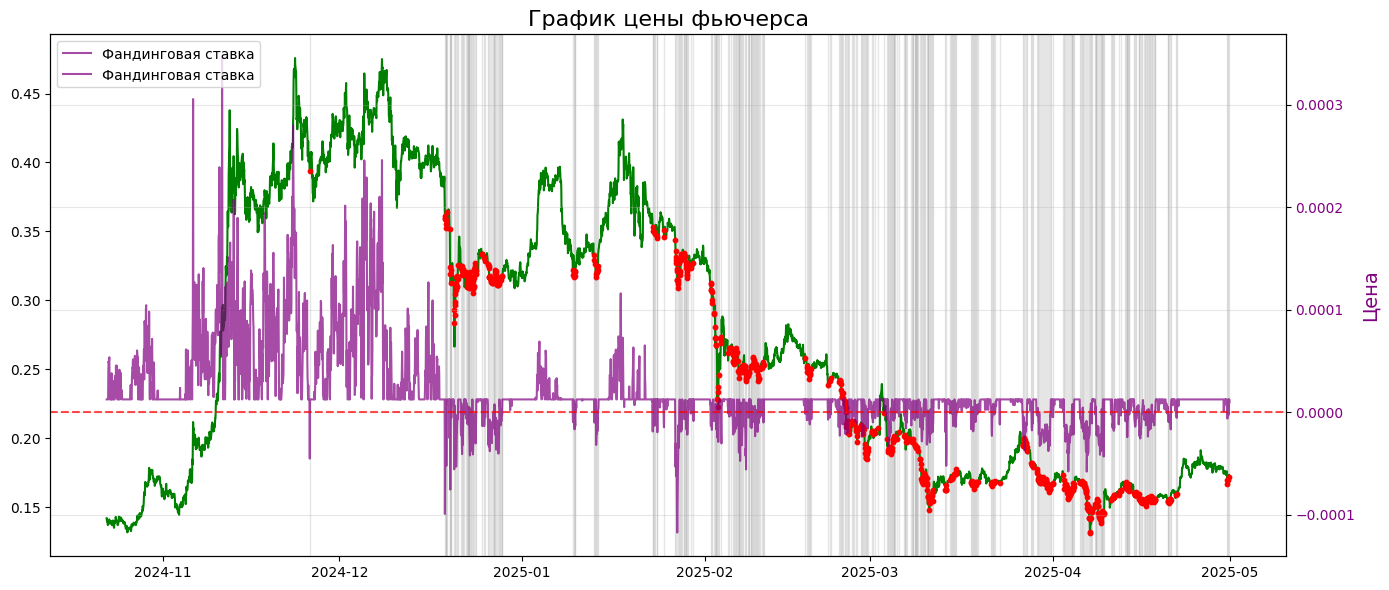


Результаты анализа периодов с высокой вероятностью отрицательной ставки:
день: 119 из 720 (16.5%)
неделя: 13 из 104 (12.5%)
месяц: 5 из 24 (20.8%)


In [34]:
DOGE_frs = HyperliquidFundingRatesLoader(ticker = 'DOGE', start_time=start_time, end_time=end_time).read(with_run=True)
DOGE_futures_prices = HyperLiquidPerpsPricesLoader(ticker='DOGE', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

results, _ = analyze_negative_funding_periods(
    DOGE_frs,
    threshold_prob=0.7,
    figsize=(14, 20),
    periods={'день': 'D', 'неделя': 'W', 'месяц': 'M'}
)

plot_futures_price(DOGE_futures_prices, DOGE_frs)

print("\nРезультаты анализа периодов с высокой вероятностью отрицательной ставки:")
for period, stats in results.items():
    print(f"{period}: {stats['high_prob_periods']} из {stats['total_periods']} "
          f"({stats['percentage']:.1f}%)")

<ipython-input-32-69cff84bdb1a>:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = negative.resample(period_alias).agg(['sum', 'count'])


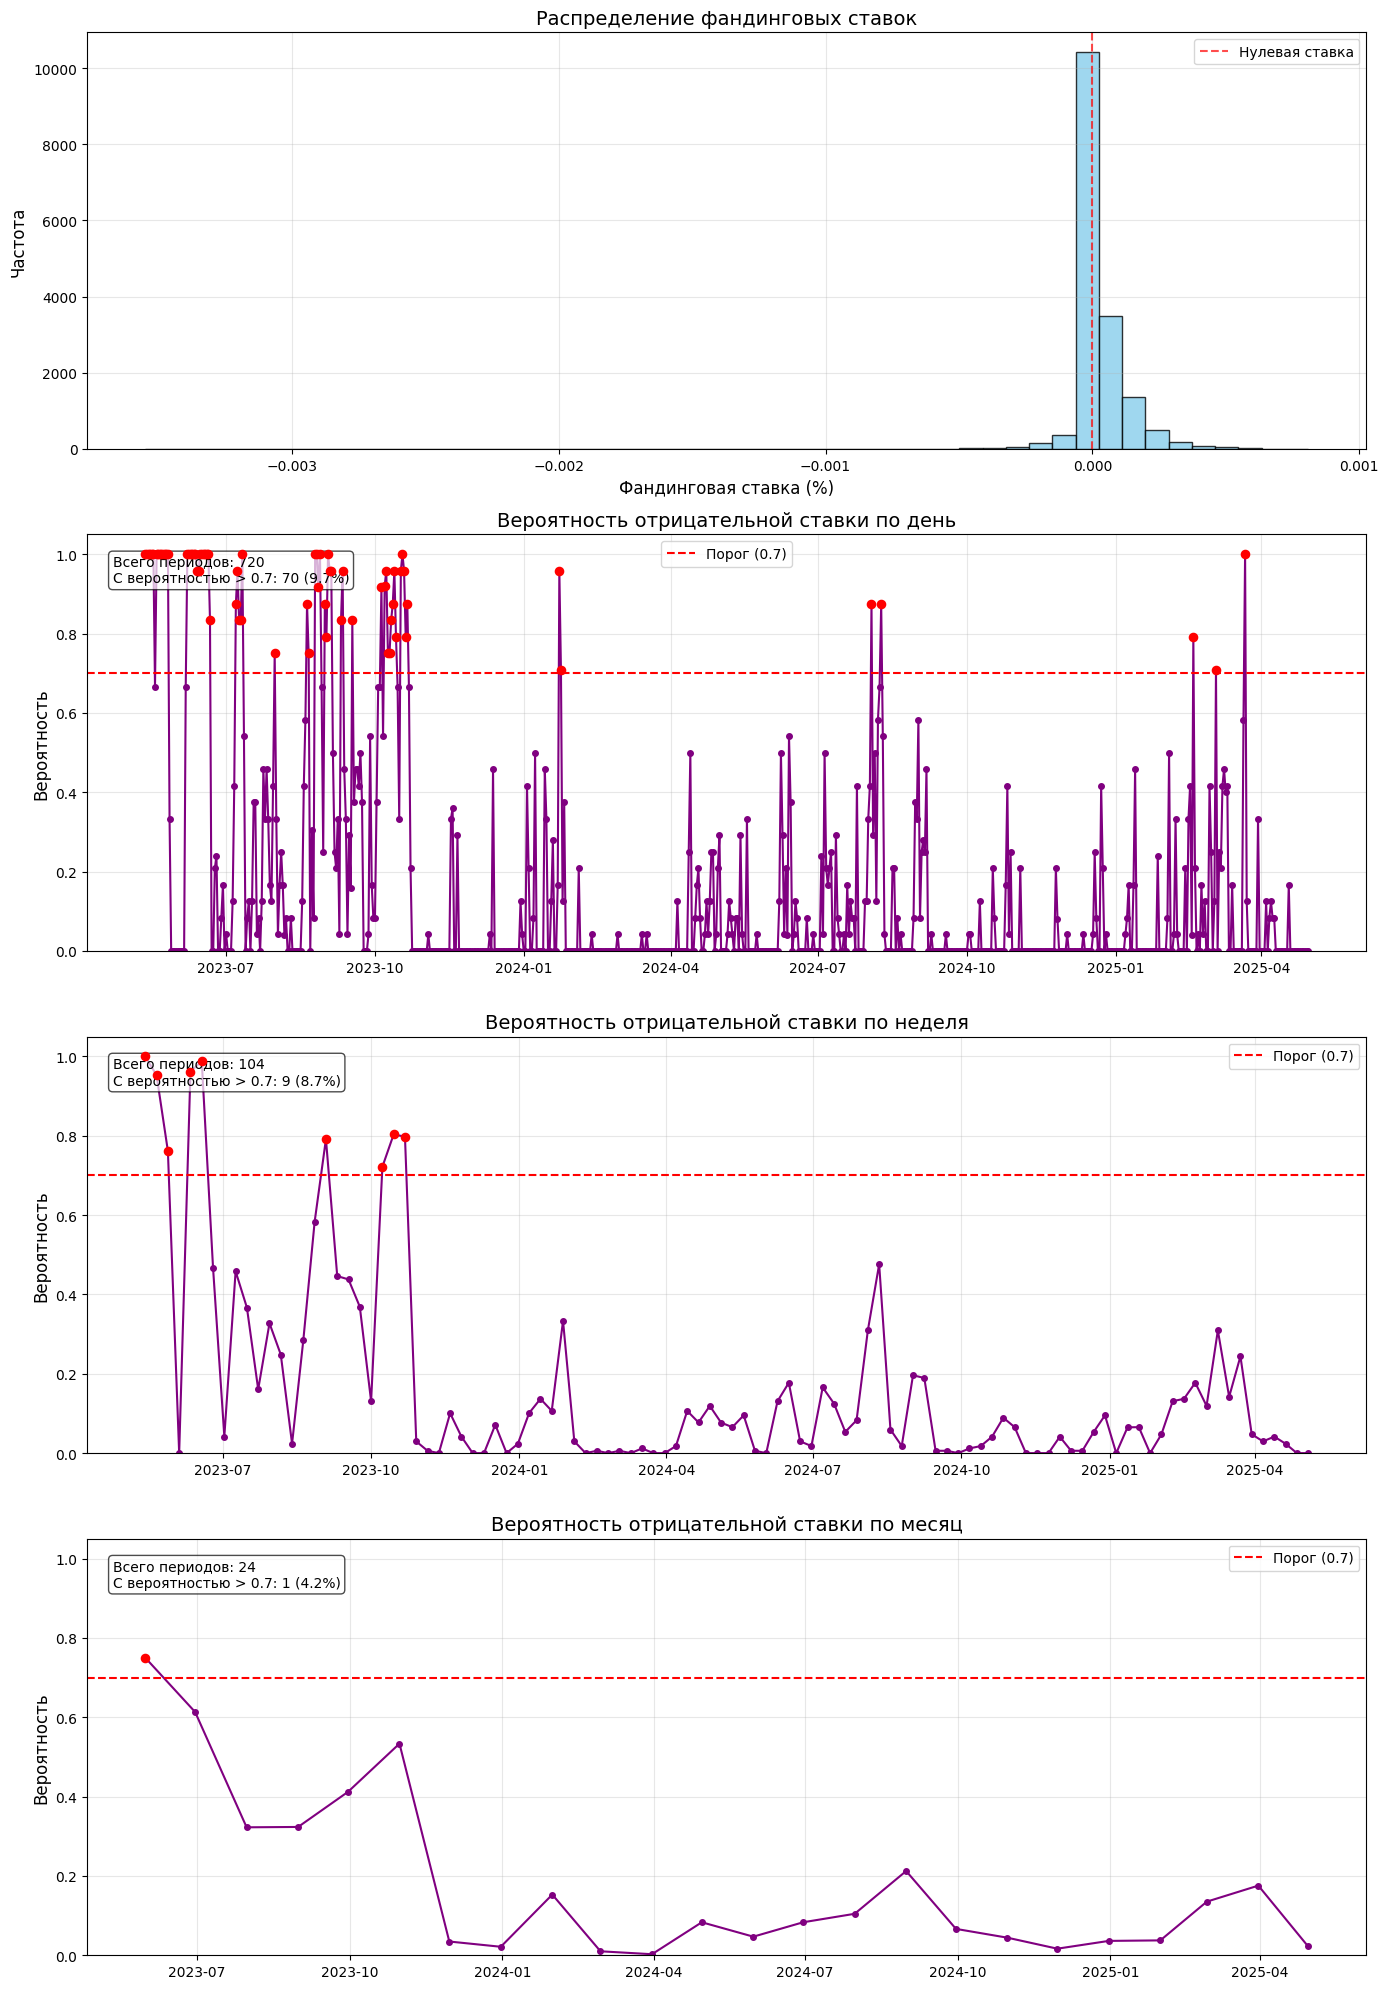

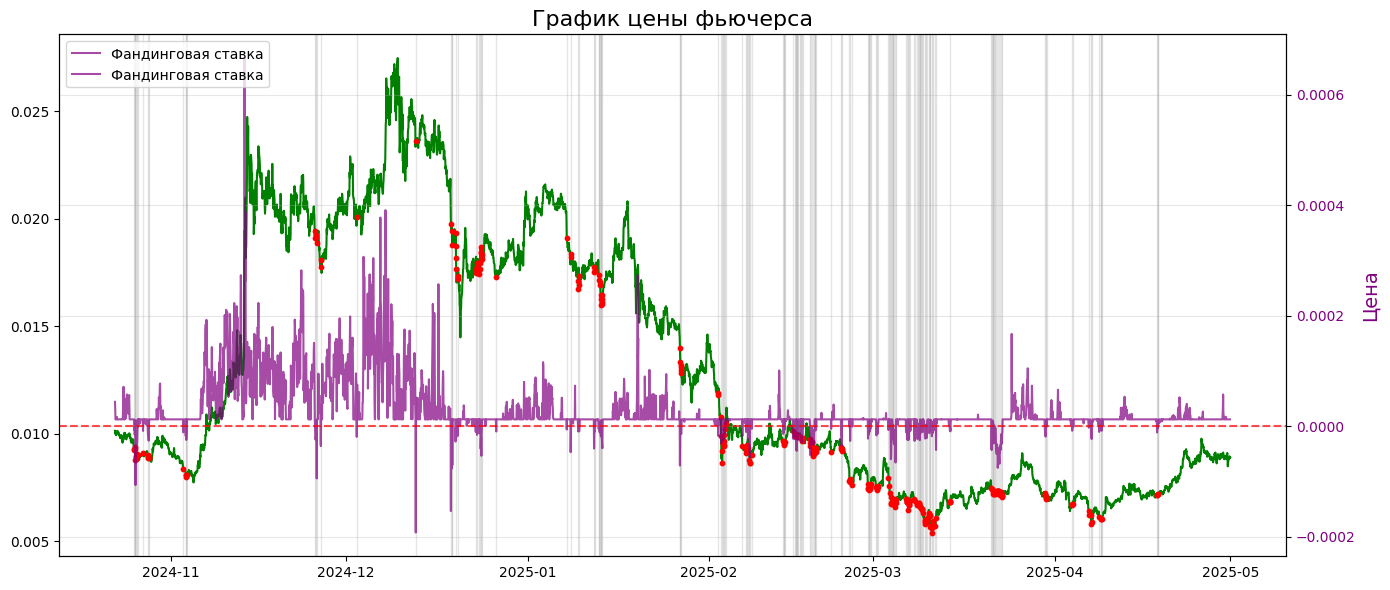


Результаты анализа периодов с высокой вероятностью отрицательной ставки:
день: 70 из 720 (9.7%)
неделя: 9 из 104 (8.7%)
месяц: 1 из 24 (4.2%)


In [35]:
PEPE_frs = HyperliquidFundingRatesLoader(ticker = 'kPEPE', start_time=start_time, end_time=end_time).read(with_run=True)
PEPE_futures_prices = HyperLiquidPerpsPricesLoader(ticker='kPEPE', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

results, _ = analyze_negative_funding_periods(
    PEPE_frs,
    threshold_prob=0.7,
    figsize=(14, 20),
    periods={'день': 'D', 'неделя': 'W', 'месяц': 'M'}
)

plot_futures_price(PEPE_futures_prices, PEPE_frs)

print("\nРезультаты анализа периодов с высокой вероятностью отрицательной ставки:")
for period, stats in results.items():
    print(f"{period}: {stats['high_prob_periods']} из {stats['total_periods']} "
          f"({stats['percentage']:.1f}%)")

<ipython-input-32-69cff84bdb1a>:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = negative.resample(period_alias).agg(['sum', 'count'])


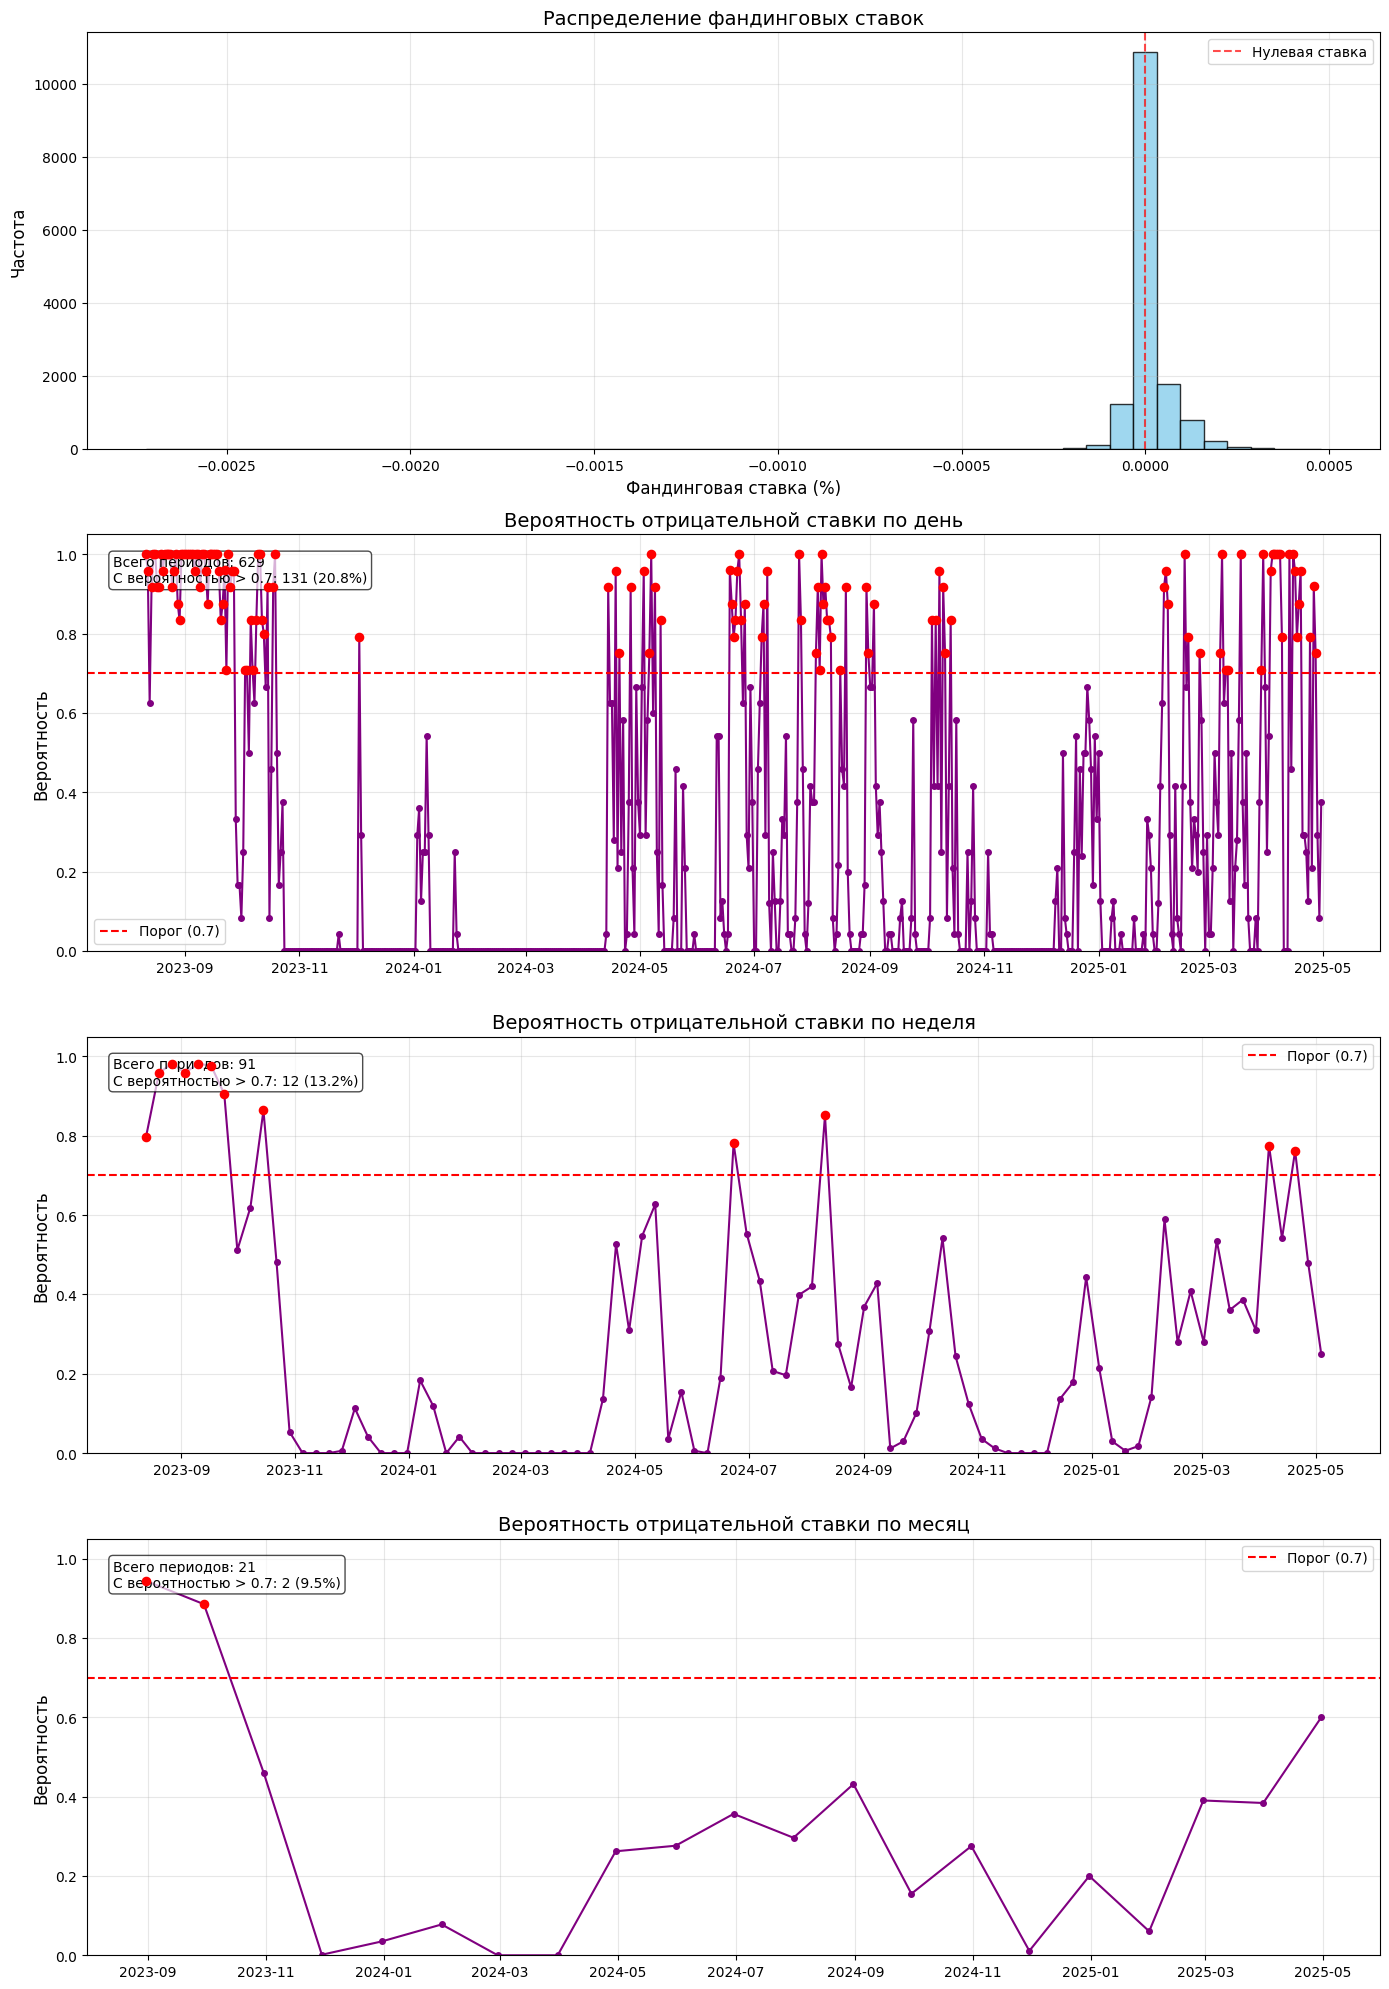

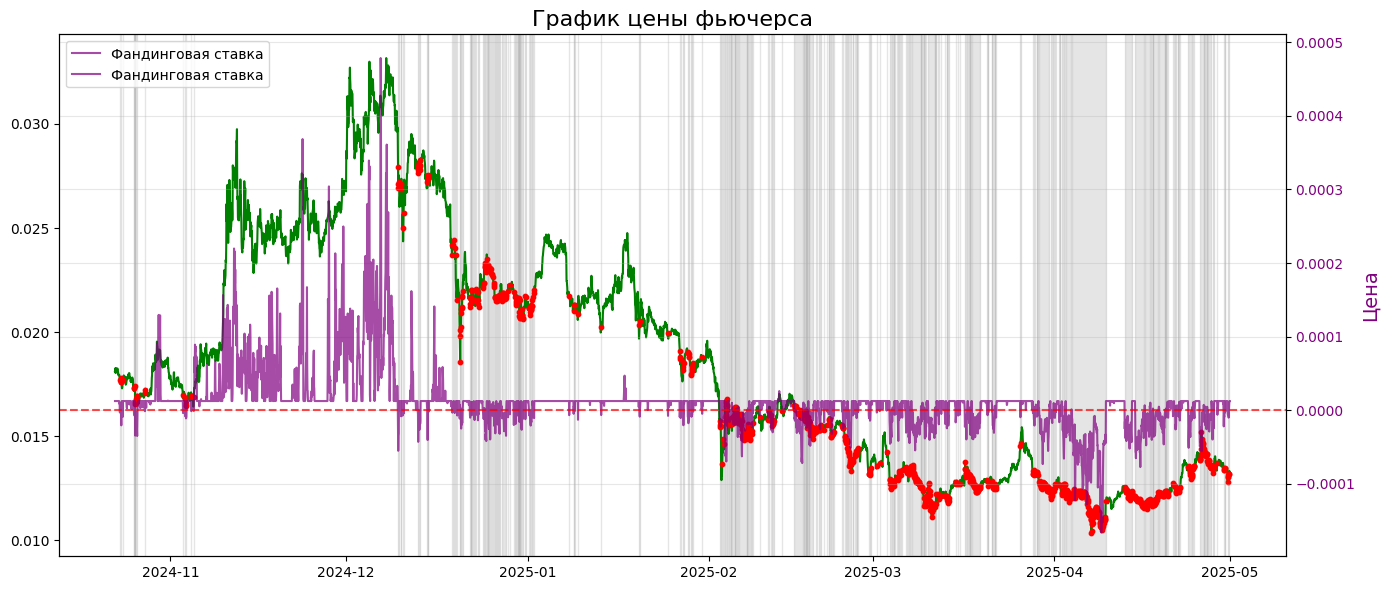


Результаты анализа периодов с высокой вероятностью отрицательной ставки:
день: 131 из 629 (20.8%)
неделя: 12 из 91 (13.2%)
месяц: 2 из 21 (9.5%)


In [36]:
SHIB_frs = HyperliquidFundingRatesLoader(ticker = 'kSHIB', start_time=start_time, end_time=end_time).read(with_run=True)
SHIB_futures_prices = HyperLiquidPerpsPricesLoader(ticker='kSHIB', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

results, _ = analyze_negative_funding_periods(
    SHIB_frs,
    threshold_prob=0.7,
    figsize=(14, 20),
    periods={'день': 'D', 'неделя': 'W', 'месяц': 'M'}
)

plot_futures_price(SHIB_futures_prices, SHIB_frs)

print("\nРезультаты анализа периодов с высокой вероятностью отрицательной ставки:")
for period, stats in results.items():
    print(f"{period}: {stats['high_prob_periods']} из {stats['total_periods']} "
          f"({stats['percentage']:.1f}%)")

#Выводы

По данным, которые мы нашли - у PEPE, SHIB и DOGE есть очень много периодов длины день или неделя когда фандиговая ставка большую часть времени(>70%) была отрицательной - это очень хороший маркер для того, чтобы зайти в эти рынки для торговли по нашей стратегии, так как велик шанс того, что мы можем попасть в длительный период с отрицательной ставкой.

#?

In [6]:
hyperliquid_prices = HyperLiquidPerpsPricesLoader(ticker='ETH', interval='1h').read(with_run=True)

In [7]:
hyperliquid_prices

,price
open_time,
2025-01-01 00:00:00+00:00,3336.8
2025-01-01 01:00:00+00:00,3363.8
2025-01-01 02:00:00+00:00,3347.0
2025-01-01 03:00:00+00:00,3363.4
2025-01-01 04:00:00+00:00,3356.3
...,...
2025-05-18 09:00:00+00:00,2517.3
2025-05-18 10:00:00+00:00,2507.7
2025-05-18 11:00:00+00:00,2504.9


In [ ]:
pool_data = UniswapV3EthereumPoolHourDataLoader(api_key=, pool='0x11b815efB8f581194ae79006d24E0d814B7697F6')

<ipython-input-11-df60cabcf2c6>:118: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(end=now, periods=30*24, freq='H')


Периоды с данными о цене: 720
Периоды с данными о ставке: 720


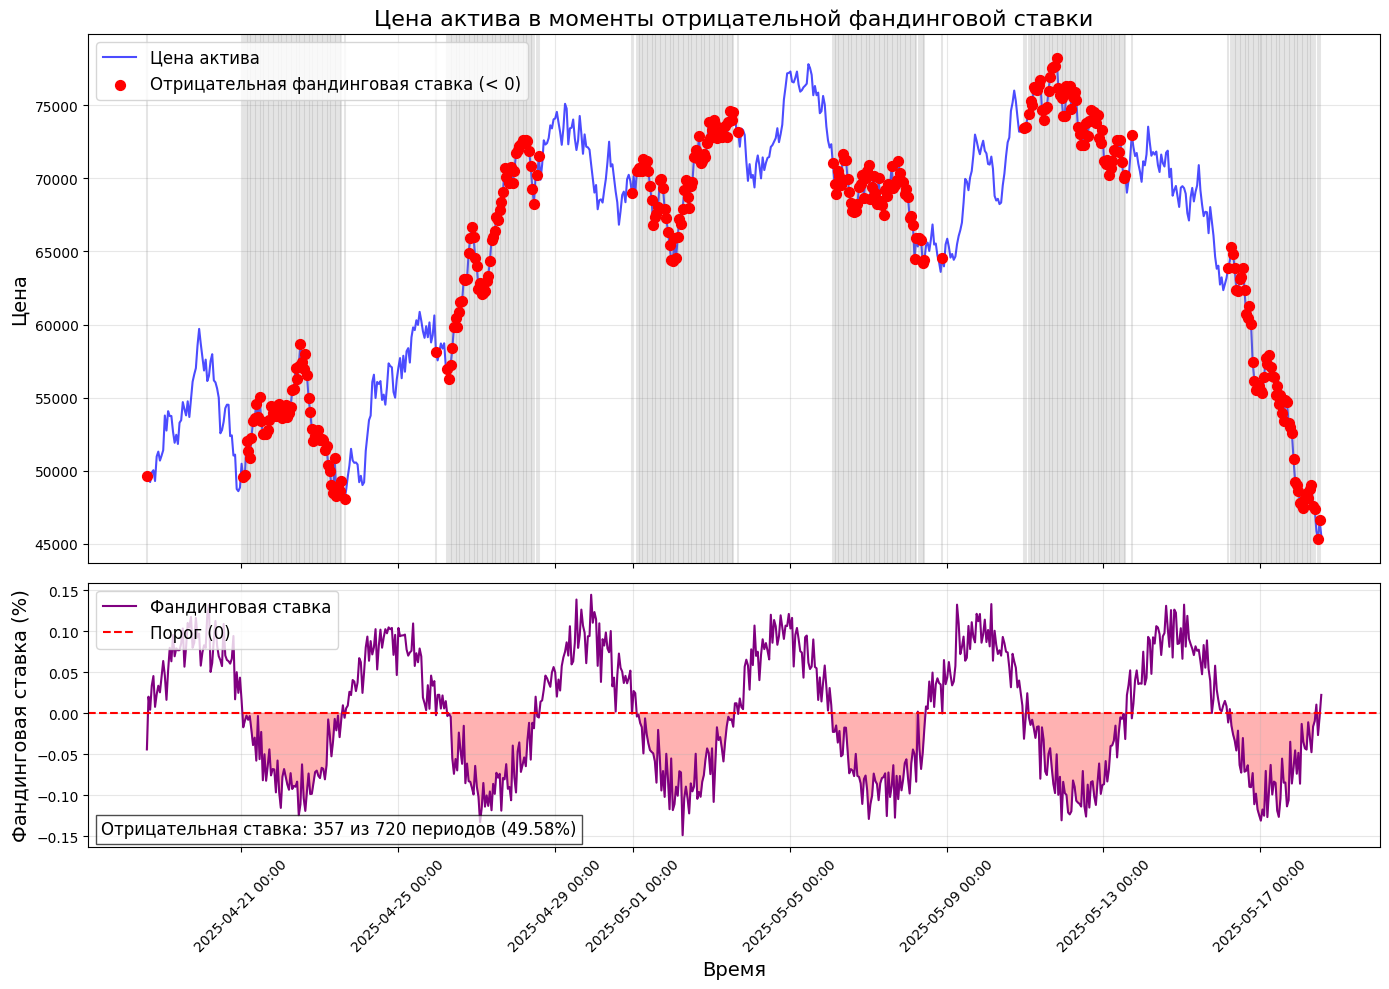


Статистика отрицательной фандинговой ставки:
Периоды с отрицательной ставкой: 357 из 720 (49.58%)
Средняя цена во время отрицательной ставки: 64659.584660361754
Общая средняя цена: 65001.3201091462
Корреляция между ценой и фандинговой ставкой: 0.0553


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def plot_price_at_negative_funding_from_dfs(price_df, rate_df, price_col='price', rate_col='rate', threshold=0):
    """
    Визуализирует цену актива и отмечает точки, где фандинговая ставка отрицательна.

    Параметры:
    price_df (pd.DataFrame): DataFrame с индексом времени и столбцом цены
    rate_df (pd.DataFrame): DataFrame с индексом времени и столбцом фандинговой ставки
    price_col (str): имя столбца с ценой в price_df
    rate_col (str): имя столбца с фандинговой ставкой в rate_df
    threshold (float): Порог для определения отрицательной ставки (по умолчанию 0)
    """
    # Объединяем два DataFrame по индексу времени
    combined_df = pd.merge(price_df[[price_col]], rate_df[[rate_col]],
                          left_index=True, right_index=True, how='inner')

    # Фильтрация данных для отрицательной фандинговой ставки
    negative_funding_mask = combined_df[rate_col] < threshold
    negative_funding_prices = combined_df.loc[negative_funding_mask, price_col]
    negative_funding_times = combined_df.index[negative_funding_mask]

    # Создаем подграфики: цена сверху, фандинговая ставка снизу
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                  gridspec_kw={'height_ratios': [2, 1]})

    # График цены
    ax1.plot(combined_df.index, combined_df[price_col], label='Цена актива', color='blue', alpha=0.7)
    ax1.scatter(negative_funding_times, negative_funding_prices, color='red',
                label=f'Отрицательная фандинговая ставка (< {threshold})', zorder=5, s=50)

    # Форматирование графика цены
    ax1.set_title('Цена актива в моменты отрицательной фандинговой ставки', fontsize=16)
    ax1.set_ylabel('Цена', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    # Выделение областей с отрицательной фандинговой ставкой
    for idx in negative_funding_times:
        ax1.axvline(x=idx, color='gray', alpha=0.2)

    # График фандинговой ставки
    ax2.plot(combined_df.index, combined_df[rate_col], color='purple', label='Фандинговая ставка')
    ax2.axhline(y=threshold, color='red', linestyle='--', label=f'Порог ({threshold})')

    # Заливка для отрицательных областей
    ax2.fill_between(combined_df.index, combined_df[rate_col], threshold,
                    where=(combined_df[rate_col] < threshold), color='red', alpha=0.3)

    # Форматирование графика фандинговой ставки
    ax2.set_ylabel('Фандинговая ставка (%)', fontsize=14)
    ax2.set_xlabel('Время', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)

    # Форматирование дат на оси X
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # Статистика
    neg_funding_count = negative_funding_mask.sum()
    total_periods = len(combined_df)
    neg_funding_pct = (neg_funding_count / total_periods) * 100

    ax2.text(0.01, 0.05, f'Отрицательная ставка: {neg_funding_count} из {total_periods} периодов ({neg_funding_pct:.2f}%)',
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.7), fontsize=12)

    plt.tight_layout()
    plt.show()

    # Возвращаем статистику для дальнейшего анализа
    return {
        'negative_funding_periods': neg_funding_count,
        'total_periods': total_periods,
        'negative_funding_percentage': neg_funding_pct,
        'avg_price_during_negative': negative_funding_prices.mean() if len(negative_funding_prices) > 0 else None,
        'avg_price_overall': combined_df[price_col].mean(),
        'correlation': combined_df[rate_col].corr(combined_df[price_col])
    }

# Пример использования с реальными данными
def analyze_real_data(price_df, rate_df, price_column='price', rate_column='rate'):
    """
    Анализирует реальные данные о цене и фандинговой ставке.

    Параметры:
    price_df: DataFrame с индексом времени и ценами
    rate_df: DataFrame с индексом времени и фандинговыми ставками
    price_column: имя столбца с ценой (по умолчанию 'price')
    rate_column: имя столбца с фандинговой ставкой (по умолчанию 'rate')
    """
    # Проверяем формат данных
    print(f"Периоды с данными о цене: {len(price_df)}")
    print(f"Периоды с данными о ставке: {len(rate_df)}")

    # Анализируем данные
    stats = plot_price_at_negative_funding_from_dfs(
        price_df, rate_df,
        price_col=price_column,
        rate_col=rate_column
    )

    print("\nСтатистика отрицательной фандинговой ставки:")
    print(f"Периоды с отрицательной ставкой: {stats['negative_funding_periods']} из {stats['total_periods']} ({stats['negative_funding_percentage']:.2f}%)")
    print(f"Средняя цена во время отрицательной ставки: {stats['avg_price_during_negative']}")
    print(f"Общая средняя цена: {stats['avg_price_overall']}")
    print(f"Корреляция между ценой и фандинговой ставкой: {stats['correlation']:.4f}")

    return stats

# Пример использования с синтетическими данными
if __name__ == '__main__':
    # Создание временного индекса (почасовые данные за последние 30 дней)
    now = pd.Timestamp.now()
    dates = pd.date_range(end=now, periods=30*24, freq='H')

    # Синтетические данные для цены
    base_price = 50000
    trend = np.linspace(0, 5000, len(dates))
    noise = np.random.normal(0, 1000, len(dates)).cumsum()
    price_data = pd.DataFrame({'price': base_price + trend + noise}, index=dates)

    # Синтетические данные для фандинговой ставки
    base_funding = np.sin(np.linspace(0, 12*np.pi, len(dates))) * 0.1
    funding_noise = np.random.normal(0, 0.02, len(dates))
    rate_data = pd.DataFrame({'rate': base_funding + funding_noise}, index=dates)

    analyze_real_data(price_data, rate_data)


In [10]:
stats = plot_price_at_negative_funding(hyperliquid_frs, hyperliquid_prices)

print("\nСтатистика отрицательной фандинговой ставки:")
print(f"Периоды с отрицательной ставкой: {stats['negative_funding_periods']} из {stats['total_periods']} ({stats['negative_funding_percentage']:.2f}%)")
print(f"Средняя цена во время отрицательной ставки: {stats['avg_price_during_negative']}")
print(f"Общая средняя цена: {stats['avg_price_overall']}")
print(f"Корреляция между ценой и фандинговой ставкой: {stats['correlation']:.4f}")

ValueError: putmask: mask and data must be the same size